In [1]:
import pandas as pd

data = pd.read_csv('./datasets/广告投放数据表.csv')

data

,douyin,kuaishou,wechat,sales
0,23.01,3.78,6.92,66.3
1,4.45,3.93,4.51,31.2
2,1.72,4.59,6.93,36.0
3,15.15,4.13,5.85,49.5
4,18.08,1.08,5.84,53.7
...,...,...,...,...
195,3.82,0.37,1.38,22.8
196,9.42,0.49,0.81,42.0
197,17.70,0.93,0.64,44.4
198,28.36,4.20,6.62,76.5


In [3]:
from sklearn.linear_model import LinearRegression
X = data[['douyin', 'kuaishou', 'wechat']]
y = data['sales']


In [7]:
import statsmodels.api as sm

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

# 获取参数
coef = model.coef_
intercept = model.intercept_
r2 = model.score(X, y)

print("\n=== sklearn 回归结果 ===")
print(f"截距 (基础销售额): {intercept:.2f}")
print(f"douyin 系数: {coef[0]:.3f} → 每多投1元 抖音，销售额增加 {coef[0]:.3f} 元")
print(f"kuaishou 系数: {coef[1]:.3f} → 每多投1元 快手，销售额增加 {coef[1]:.3f} 元")
print(f"wechat 系数: {coef[2]:.3f} → 每多投1元 微信视频号，销售额增加 {coef[2]:.3f} 元")
print(f"R²: {r2:.3f}")

# ----------------------------
# 3. 使用 statsmodels 获取 p 值（判断显著性）
# ----------------------------
X_sm = sm.add_constant(X)  # 添加截距项
ols_model = sm.OLS(y, X_sm).fit()
print("\n=== statsmodels 回归摘要（含 p 值）===")
print(ols_model.summary())

# ----------------------------
# 4. 计算各渠道的平均 ROI（可选）
# ----------------------------
# ROI = (带来的销售额增量) / 投放额
# 注意：这里用的是边际 ROI（每1元的效果），不是总 ROI
marginal_roi = coef  # 即每1元投入带来的销售额

avg_spend = X.mean()
total_effect = pd.Series(model.coef_ * avg_spend, index=X.columns)  # 保持列名

print("\n=== 渠道效果分析 ===")
for name in X.columns:
    coef_val = model.coef_[X.columns.get_loc(name)]
    print(f"{name}:")
    print(f"  - 平均投放: {avg_spend[name]:.1f} 元")
    print(f"  - 边际 ROI (每1元带来销售额): {coef_val:.3f} 元")
    print(f"  - 平均贡献销售额: {total_effect[name]:.1f} 元")
    print()



=== sklearn 回归结果 ===
截距 (基础销售额): 13.88
douyin 系数: 1.633 → 每多投1元 抖音，销售额增加 1.633 元
kuaishou 系数: 3.210 → 每多投1元 快手，销售额增加 3.210 元
wechat 系数: 0.010 → 每多投1元 微信视频号，销售额增加 0.010 元
R²: 0.903

=== statsmodels 回归摘要（含 p 值）===
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     605.4
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           8.13e-99
Time:                        14:12:32   Log-Likelihood:                -603.06
No. Observations:                 200   AIC:                             1214.
Df Residuals:                     196   BIC:                             1227.
Df Model:                           3                                         
Covariance Type:            nonrobust                                       

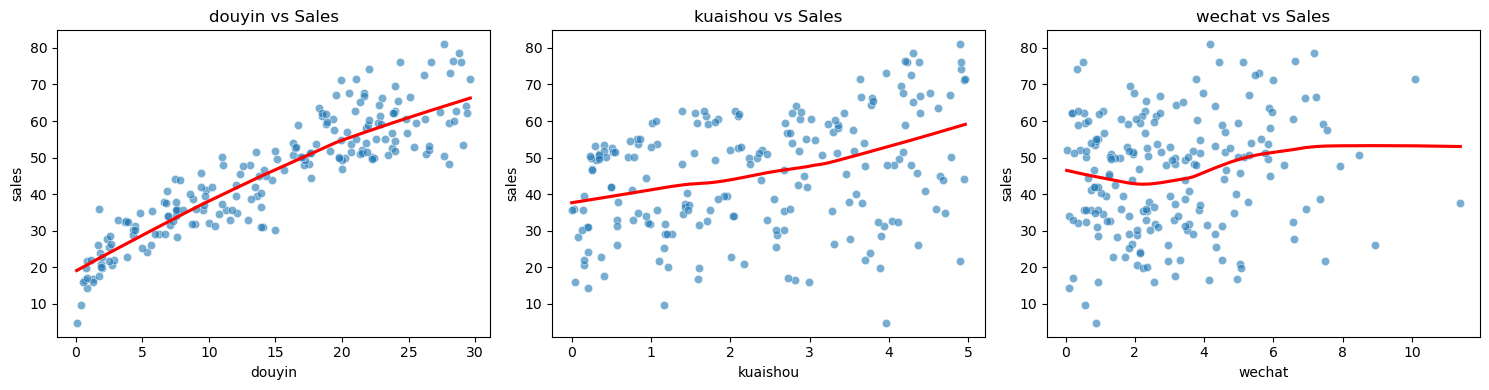

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 data 包含 'douyin', 'kuaishou', 'wechat', 'sales'
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['douyin', 'kuaishou', 'wechat']):
    sns.scatterplot(x=data[col], y=data['sales'], ax=axes[i], alpha=0.6)
    sns.regplot(x=data[col], y=data['sales'],
                lowess=True,          # 关键：添加非参数平滑线
                scatter=False,
                color='red',
                ax=axes[i])
    axes[i].set_title(f'{col} vs Sales')
plt.tight_layout()
plt.show()

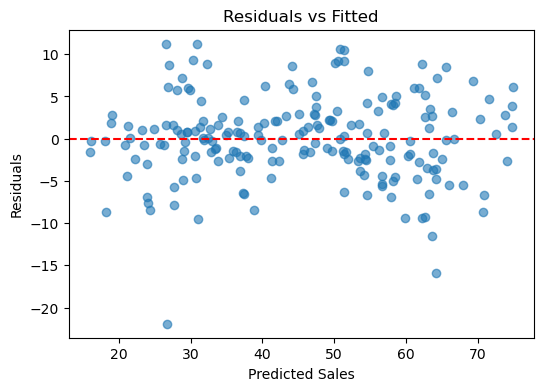

In [17]:
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

In [10]:

# 以 kuaishou 为例
data['kuaishou_sq'] = data['kuaishou'] ** 2
X_test = sm.add_constant(data[['douyin', 'kuaishou', 'kuaishou_sq', 'wechat']])
model_poly = sm.OLS(data['sales'], X_test).fit()
print(model_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     477.3
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           1.70e-99
Time:                        14:28:14   Log-Likelihood:                -598.08
No. Observations:                 200   AIC:                             1206.
Df Residuals:                     195   BIC:                             1223.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.9934      1.124     14.224      

In [11]:
from statsmodels.stats.diagnostic import linear_reset

# 先拟合原模型
X_orig = sm.add_constant(data[['douyin', 'kuaishou', 'wechat']])
model_orig = sm.OLS(data['sales'], X_orig).fit()

# 执行 RESET 检验（默认加入 y_hat^2, y_hat^3）
reset_result = linear_reset(model_orig, power=2, test_type='fitted')
print("RESET 检验 p 值:", reset_result.pvalue)

RESET 检验 p 值: 0.14341723019174854


In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# 线性模型
linear_pipe = Pipeline([('reg', LinearRegression())])

# 二次多项式模型（仅对关键变量，避免维度爆炸）
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
# 注意：可只对 kuaishou 做非线性扩展，更安全

# 简化：只对 kuaishou 加二次项
X_poly = data[['douyin', 'kuaishou', 'wechat']].copy()
X_poly['kuaishou_sq'] = data['kuaishou'] ** 2

# 交叉验证比较
cv_linear = cross_val_score(LinearRegression(), X, y, cv=5, scoring='r2').mean()
cv_poly = cross_val_score(LinearRegression(), X_poly, y, cv=5, scoring='r2').mean()

print(f"线性模型 R² (CV): {cv_linear:.3f}")
print(f"带二次项模型 R² (CV): {cv_poly:.3f}")

线性模型 R² (CV): 0.895
带二次项模型 R² (CV): 0.899


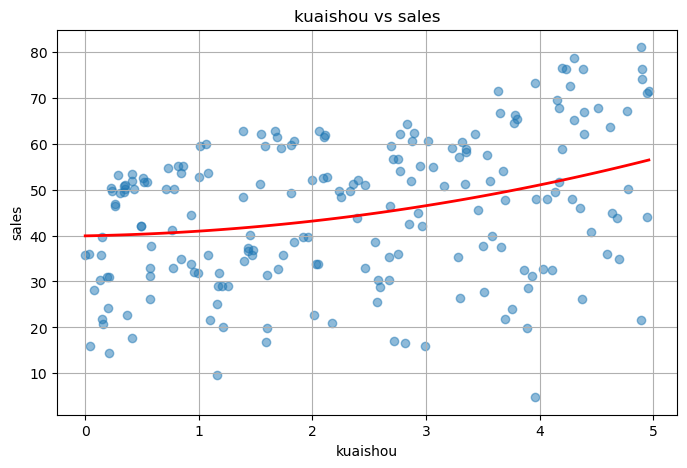

In [18]:
import numpy as np

# 固定其他变量为均值
douyin_mean = data['douyin'].mean()
wechat_mean = data['wechat'].mean()

# 生成快手投放序列
kuaishou_range = np.linspace(data['kuaishou'].min(), data['kuaishou'].max(), 100)

# 预测销售额（使用带二次项的模型）
sales_pred = (
    15.9934 +
    1.6349 * douyin_mean +
    0.4458 * kuaishou_range +
    0.5815 * (kuaishou_range ** 2) +
    (-0.0330) * wechat_mean
)

plt.figure(figsize=(8, 5))
plt.scatter(data['kuaishou'], data['sales'], alpha=0.5)
plt.plot(kuaishou_range, sales_pred, color='red', linewidth=2)
plt.xlabel('kuaishou')
plt.ylabel('sales')
plt.title('kuaishou vs sales')
plt.grid(True)
plt.show()